In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import itertools

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
leaderboard = {}

# Load the data
Load matrix and create list of samples and entries

In [3]:
df = pandas.read_csv("results/gene_allfusions_binmx.tsv", sep="\t", index_col=0)
df.columns = df.columns.map(lambda x:x.replace(".", "|"))
samples = list(set(i.split("|")[0] for i in df.columns if i not in ['fusion_key', 'fusion_id']))
entries = list(set(i.split("|")[1] for i in df.columns if i not in ['fusion_key', 'fusion_id']))
samples.remove("giab")
entries.remove("truth")

In [4]:
def getConfMatrix(df, entries, sample, truth):
    o = {}
    for e in entries:
        k = "%s|%s" % (sample, e)
        if k in df:
            pos = df[df[k] > 0].index
            tp = sum(pos.isin(truth))
            fp = sum(~pos.isin(truth))
            fn = sum(~truth.isin(pos))
            o[e] = {'tp' : tp, 'fp' : fp, 'fn' : fn}
    return o

In [5]:
def f1Score(m):
    return (2.0 * (m['tp'])) / (2.0*m['tp'] + m['fp'] + m['fn'])

In [6]:
def tprScore(m):
    return (m['tp']) / (m['tp'] + m['fn'])

In [7]:
def fdrScore(m):
    return (m['fp']) / (m['fp'] + m['tp'])

# Create overall senstivity scores

In [8]:
tpr_data = {}
fdr_data = {}
f1_data = {}
count_data = {}
tp_data = {}
call_data = {}
for s in samples:
    td = {}
    fd = {}
    t = df[ df["%s|truth" % (s)] == 1 ].index
    res = getConfMatrix(df, entries, s, t)
    tpr_data[s] = dict( (a[0], tprScore(a[1])) for a in res.items() )
    fdr_data[s] = dict( (a[0], fdrScore(a[1])) for a in res.items() )
    f1_data[s] = dict( (a[0], f1Score(a[1])) for a in res.items() )
    tp_data[s] = dict( (a[0], a[1]['tp']) for a in res.items() )
    call_data[s] = dict( (a[0], a[1]['tp'] + a[1]['fp']) for a in res.items() )
    count_data[s] = len(t)
tpr_df = pandas.DataFrame(tpr_data)
fdr_df = pandas.DataFrame(fdr_data)
f1_df = pandas.DataFrame(f1_data)
tp_df = pandas.DataFrame(tp_data)
call_df = pandas.DataFrame(call_data)
spike_count = pandas.Series(count_data)

In [9]:
leaderboard['spike_tpr'] = tpr_df.sum(axis=1) / len(samples)

In [10]:
leaderboard['spike_fdr'] = fdr_df.sum(axis=1) / len(samples)

In [11]:
leaderboard['spike_f1'] = f1_df.sum(axis=1) / len(samples)

In [12]:
leaderboard['spike_call_count'] = call_df.sum(axis=1)

In [13]:
leaderboard['spike_tp_count'] = tp_df.sum(axis=1)

In [14]:
def entryColumns(a, df):
    c = []
    for b in samples:
        k = "%s|%s" % (b, a)
        if k in df.columns:
            c.append(k)
    return c

# Build correlation matrix between all entries

In [15]:
data = {}
for i in entries:
    for j in entries:
        a = df[entryColumns(i, df)].sum(axis=1)
        b = df[entryColumns(j, df)].sum(axis=1)
        c = a.corr(b)
        data[i] = {**data.get(i, {}), **{j:c}}
        data[j] = {**data.get(j, {}), **{i:c}}
corrDF = pandas.DataFrame(data)

In [16]:
workingEntries = corrDF.columns[ corrDF.apply(lambda x:x.isnull().sum(), axis=0) != corrDF.shape[0] ]

In [17]:
def thresholdGroup(distDF, threshold):
    groupMap = pandas.Series(dict((a[1], a[0]) for a in enumerate(distDF.columns)))
    while True:
        change = False
        for i in groupMap.index:
            t = distDF.columns[distDF[i] > threshold]
            for j in t:
                if j != i and groupMap[i] != groupMap[j]:
                    n = groupMap.copy()
                    n[n==groupMap[j]] = groupMap[i]
                    if not n.equals(groupMap):
                        change = True
                    groupMap = n
        if not change:
            break
    d = {}
    for i, j in groupMap.items():
        d[j] = d.get(j, []) + [i]
    return list(d.values())

In [18]:
clines = {}
for i in samples:
    if i != 'giab':
        t = i.split("_")
        cell = t[0]
        if len(t[1]) == 1: # skip the technical replicates
            if cell in clines:
                clines[cell].append(i)
            else:
                clines[cell] = [i]

In [19]:
true_sites = set()
for c in df.columns:
    if c.endswith("|truth"):
        true_sites.update(set(df[df[c] > 0][c].index))

In [20]:
def new_truth(df, sample, new_truth):
    k = "%s|truth" % (sample)
    orig_truth = (df[k][ df[k] == 1 ]).index
    return orig_truth.append(new_truth).unique()

In [21]:
data = {}
for s in samples:
    t = df[df["%s|truth" % (s)] == 1].index
    truthTP = pandas.Series(dict((a, b['tp']) for a,b in getConfMatrix(df, entries, s, t).items()))
    data[s] = (truthTP / spike_count[s])[entries]
truthFP = pandas.DataFrame(data)

/mnt/home/ellrott/.local/lib/python3.6/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


# Build set of less-then-correlated methods, with TPR of 0.6 or better

In [22]:
entryGroups = thresholdGroup(corrDF.reindex(columns=workingEntries, index=workingEntries), 0.9)
repSet = []
for i in entryGroups:
    scores = truthFP.loc[i].mean(axis=1).sort_values(ascending=False)
    if scores[0] > 0.6:
        repSet.append(scores.index[0])

In [23]:
cellCombined = {}
cellSampleCount = {}
for c, e in clines.items():
    cols = list(b for b in ("%s|%s" % (a[0], a[1]) for a in itertools.product(e, repSet)) if b in df.columns)
    csum = df[cols].sum(axis=1)
    csum = csum[csum > 1][csum.index.difference(true_sites)].dropna()
    cellCombined[c] = csum
    cellSampleCount[c] = len(cols)

## Example TPR projection using pseudo-truths for a single cell line

In [24]:
c = "LNCapFGC"
summary = {}
for l in clines[c]:
    o = {}
    for t in sorted(cellCombined[c].value_counts().index):
        new_sites = cellCombined[c][ cellCombined[c] >= t ].index
        nt = new_truth(df, l, new_sites)
        res = getConfMatrix(df, entries, l, nt)
        o[t] = res
    summary[l] = o

In [25]:
cellCombined[c].value_counts().sort_index()

2.0     3197
3.0      524
4.0      480
5.0      161
6.0      104
7.0       42
8.0       47
9.0       18
10.0      31
11.0       3
12.0       4
13.0       3
14.0       2
15.0       1
16.0       1
18.0       1
20.0       2
25.0       1
31.0       1
35.0       1
44.0       1
45.0       1
46.0       2
49.0       2
dtype: int64

In [26]:
l = "LNCapFGC_1"
o = {}
for thres, data in summary[l].items():
    o[thres] = dict( (a[0], a[1]['tp'] / (a[1]['tp'] + a[1]['fn'])) for a in data.items() )
curveDF = pandas.DataFrame(o)

In [27]:
curveDF.loc[repSet]

,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,...,16.0,18.0,20.0,25.0,31.0,35.0,44.0,45.0,46.0,49.0
8396553,0.006024,0.019297,0.029126,0.060403,0.094406,0.148352,0.192857,0.279570,0.346667,0.590909,...,0.838710,0.833333,0.827586,0.851852,0.884615,0.92,0.916667,0.913043,0.909091,0.90
9609508,0.009897,0.030324,0.040992,0.078300,0.118881,0.170330,0.221429,0.322581,0.400000,0.681818,...,0.935484,0.966667,0.965517,0.962963,0.961538,0.96,0.958333,0.956522,0.954545,0.95
9610272,0.010542,0.033081,0.035599,0.071588,0.104895,0.164835,0.207143,0.301075,0.360000,0.613636,...,0.806452,0.833333,0.862069,0.888889,0.923077,0.92,0.916667,0.913043,0.909091,0.90
9609499,0.306583,0.496210,0.600863,0.740492,0.779720,0.824176,0.821429,0.817204,0.840000,0.772727,...,0.903226,0.900000,0.896552,0.925926,0.923077,0.92,0.916667,0.913043,0.909091,0.90
9610021,0.009251,0.028946,0.044229,0.085011,0.129371,0.192308,0.235714,0.344086,0.413333,0.704545,...,0.870968,0.900000,0.931034,0.925926,0.923077,0.92,0.916667,0.913043,0.909091,0.90
8644608,0.014845,0.042040,0.060410,0.114094,0.139860,0.203297,0.235714,0.344086,0.413333,0.704545,...,0.870968,0.900000,0.931034,0.925926,0.923077,0.96,0.958333,0.956522,0.954545,0.95
8517255,0.008176,0.026189,0.038835,0.076063,0.111888,0.159341,0.207143,0.311828,0.373333,0.636364,...,0.774194,0.800000,0.793103,0.851852,0.846154,0.88,0.916667,0.913043,0.909091,0.90
8040408,0.093158,0.137836,0.127292,0.136465,0.143357,0.203297,0.250000,0.354839,0.413333,0.659091,...,0.774194,0.800000,0.827586,0.851852,0.884615,0.92,0.916667,0.913043,0.909091,0.90
9609498,0.210628,0.290834,0.380798,0.472036,0.646853,0.686813,0.742857,0.752688,0.813333,0.727273,...,0.806452,0.800000,0.793103,0.851852,0.884615,0.92,0.916667,0.913043,0.909091,0.90
8399080,0.062177,0.070986,0.084142,0.087248,0.122378,0.181319,0.221429,0.311828,0.373333,0.636364,...,0.838710,0.833333,0.862069,0.888889,0.923077,0.92,0.916667,0.913043,0.909091,0.90


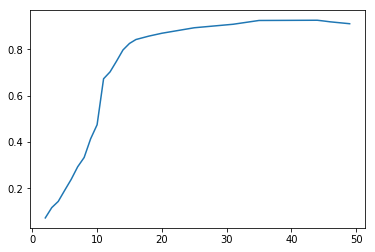

In [28]:
plt.plot(curveDF.loc[repSet].mean())

# Calculate TPR rate against psuedo truth (as determined by number of overlap sites)

In [29]:
summary = {}
for c in clines:
    for l in clines[c]:
        o = {}
        for t in sorted(cellCombined[c].value_counts().index):
            new_sites = cellCombined[c][ cellCombined[c] >= t ].index
            nt = new_truth(df, l, new_sites)
            res = getConfMatrix(df, repSet, l, nt)
            o[t / cellSampleCount[c]] = pandas.Series( dict( (a[0], a[1]['tp'] / (a[1]['tp'] + a[1]['fn'])) for a in res.items()) ).mean()
        summary[l] = o
        

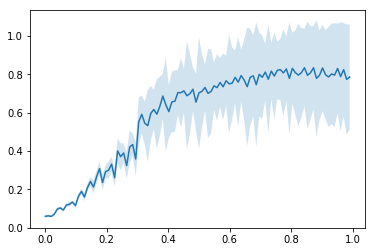

In [30]:
sumdf = pandas.DataFrame(summary)
x = np.arange(sumdf.shape[0]) / sumdf.shape[0]
ymean = sumdf.mean(axis=1)
yerr = sumdf.std(axis=1)

plt.plot(x, ymean)
plt.fill_between(x, ymean - yerr, ymean + yerr,
                alpha=0.2, )
#sumdf.mean(axis=1).plot(yerr=sumdf.std(axis=1))

# Do the same psuedo calculation for the known truth set, and plot TPR

In [31]:
data = {}
for l in samples:
    ts = df.loc[df["%s|truth" % (l)] == 1]
    osum = df[ df.columns.intersection( list("%s|%s" % (l, e) for e in repSet )) ].loc[df["%s|truth" % l] == 1].sum(axis=1)
    o = {}
    for t in sorted(osum.value_counts().index):
        if t > 1:
            nt = osum[ osum >= t ].index
            res = getConfMatrix(df, repSet, l, nt)
            o[t / len(repSet)] = dict( (a[0], a[1]['tp'] / (a[1]['tp'] + a[1]['fn'])) for a in res.items() )
    data[l] = pandas.DataFrame(o).mean()

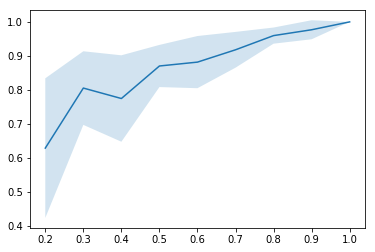

In [32]:
d = pandas.DataFrame(data).transpose()

ymean = d.mean()
yerr = d.std()

plt.plot(d.columns, ymean)
plt.fill_between(d.columns, ymean - yerr, ymean + yerr,
                alpha=0.2 )

In [33]:
psuedoThresh = 0.5
pf1_data = {}
ptpr_data = {}
pfdr_data = {}
ptp_data = {}
for c in clines:
    t = cellSampleCount[c] * psuedoThresh
    new_sites = cellCombined[c][ cellCombined[c] >= t ].index
    for l in clines[c]:
        nt = new_truth(df, l, new_sites)
        res = getConfMatrix(df, entries, l, nt)
        pf1_data[l] = pandas.Series( dict( (a[0], f1Score(a[1])) for a in res.items()) )
        ptpr_data[l] = pandas.Series( dict( (a[0], tprScore(a[1])) for a in res.items()) )
        pfdr_data[l] = pandas.Series( dict( (a[0], fdrScore(a[1])) for a in res.items()) )
        ptp_data[l] =  pandas.Series( dict( (a[0], a[1]['tp']) for a in res.items()) )
        

In [34]:
leaderboard["psuedo_f1"] = pandas.DataFrame(pf1_data).mean(axis=1)
leaderboard["psuedo_tpr"] = pandas.DataFrame(ptpr_data).mean(axis=1)
leaderboard["psuedo_fdr"] = pandas.DataFrame(pfdr_data).mean(axis=1)
leaderboard["psuedo_tp_count"] = pandas.DataFrame(ptp_data).sum(axis=1)

In [35]:
pandas.DataFrame(leaderboard).rank()

,spike_tpr,spike_fdr,spike_f1,spike_call_count,spike_tp_count,psuedo_f1,psuedo_tpr,psuedo_fdr,psuedo_tp_count
7269246,2.0,23.0,2.0,18.0,2.0,2.0,1.0,23.0,1.0
7488045,5.0,22.0,3.0,20.0,5.0,3.0,6.0,22.0,6.0
8040408,16.0,18.0,5.0,23.0,16.0,5.0,19.0,20.0,15.0
8071387,8.0,11.0,14.0,11.0,8.0,11.0,8.0,13.0,8.0
8114525,10.0,12.0,12.0,15.0,10.0,14.0,14.0,10.0,12.0
8226744,6.0,17.0,10.0,12.0,6.0,9.0,5.0,17.0,5.0
8281648,14.0,6.0,19.0,8.0,14.0,20.0,22.0,6.0,16.0
8396553,20.0,5.0,20.0,7.0,20.0,19.0,15.0,5.0,17.5
8399080,23.0,19.0,9.0,21.0,23.0,10.0,20.0,18.0,21.0
8517255,9.0,7.0,16.0,10.0,9.0,17.0,11.0,8.0,11.0


In [36]:
leadDF = pandas.DataFrame(leaderboard) 

In [37]:
c = ["tpr", "f1", "fdr"]
ave_data = {}
for a in c:    
    ave_data[ "ave_%s" % a ] = pandas.DataFrame( [ leadDF[ "spike_%s" % a ], leadDF[ "psuedo_%s" % a] ] ).mean()
aveDF = pandas.DataFrame(ave_data)

In [38]:
decending = ["spike_tpr", "spike_f1", "psuedo_tpr", "psuedo_f1"]
acending = ["spike_fdr", "psuedo_fdr"]
leadRankDF = leadDF[decending].join(1.0 - leadDF[acending]).rank(ascending=False).rename(columns=lambda x: x+"_rank")

In [39]:
leaderboard = leadDF.join(leadRankDF).join(aveDF).rename(columns=lambda x:"gene_" + x)

In [40]:
leaderboard.to_csv("fusion_gene_leaderboard.tsv", sep="\t")